In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import pickle

sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

In [2]:
def confidence_fn(carto_data, y_true):
    p_true_list = []
    for p in carto_data:
        p_true = p[np.arange(len(y_true)), y_true]
        p_true_list.append(p_true)
        
    p_true_list = np.stack(p_true_list, axis=1)
    return p_true_list.mean(axis=1)

def variability_fn(carto_data, y_true):
    mi = confidence_fn(carto_data, y_true)
    sigma_list = []
    for p in carto_data:
        p_true = p[np.arange(len(y_true)), y_true]
        sigma_list.append((p_true - mi)**2)
    
    sigma_list = np.stack(sigma_list, axis=1)
    return np.sqrt(sigma_list.mean(axis=1))

def correctness_fn(carto_data, y_true):
    correct_list = []
    y_true = np.array(y_true)
    for p in carto_data:
        correct_list.append(p.argmax(axis=1) == y_true)
        
    correct_list = np.stack(correct_list, axis=1)
    return correct_list.mean(axis=1).round(1)

In [4]:
def scatter_it(dataframe, data_name, model_name, distrib, annotate=True, show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = 'correctness'
    num_hues = len(dataframe[hue].unique().tolist())
    style = 'correctness' if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(12, 7), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(15, 260, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           hue_order=np.sort(dataframe[hue].unique())[::-1],
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    if annotate:
        bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
        an1 = ax0.annotate("ambiguous", xy=(0.8, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                      va="center", ha="center", rotation=350, bbox=bb('black'))
        an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                      va="center", ha="center", bbox=bb('r'))
        an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                      va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title("Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = dataframe.hist(column=["correctness"], color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2[0].set_title('')
        plot2[0].set_xlabel('correctness')
        plot2[0].set_ylabel('')

    fig.tight_layout()
    fig.show()
    fig.savefig(f"carto-{model_name}-{data_name}.pdf", dpi=600)

In [20]:
data_name = "AmazonReview2"
model_name = "RoBERTa"

with open(f'carto-{data_name}-{model_name}.pkl', 'rb') as f: 
    carto_data = pickle.load(f)

In [22]:
distrib = "id"
classic = True
p = carto_data[distrib]
if classic:
    y = carto_data["y_" + distrib]
else:
    y = np.array(carto_data[distrib][-1]).argmax(1).tolist()

df_data = {"confidence": confidence_fn(p, y),
          "variability": variability_fn(p, y),
          "correctness": correctness_fn(p, y)}

df = pd.DataFrame(df_data)

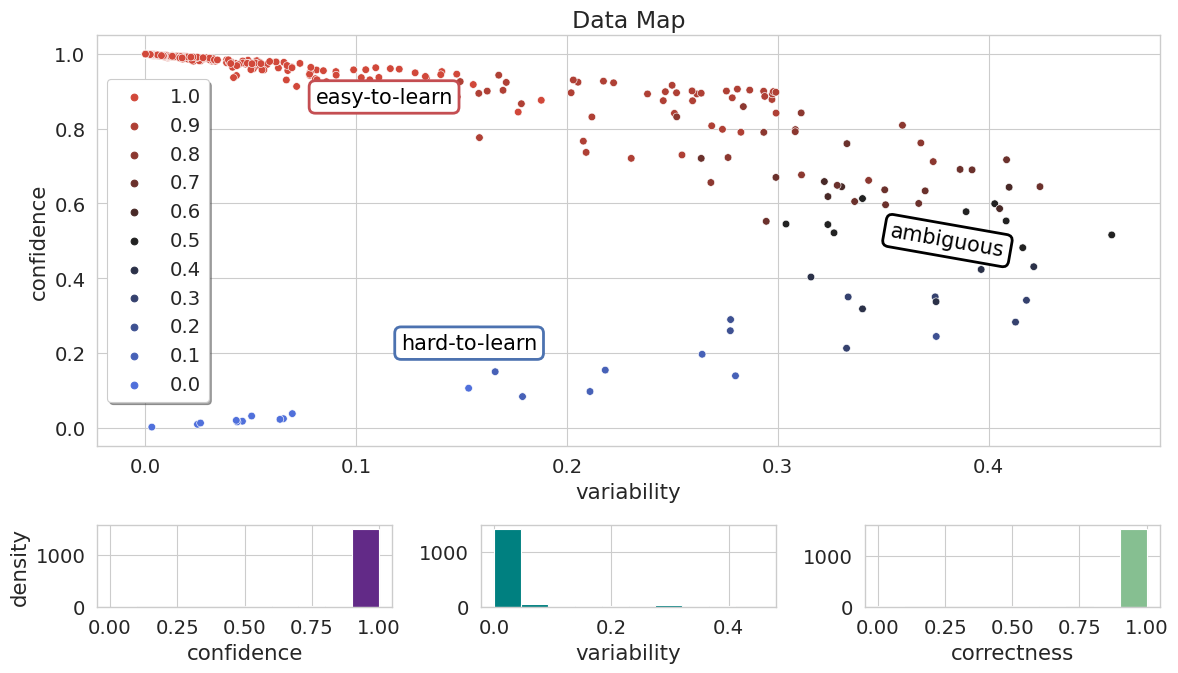

In [24]:
scatter_it(df, data_name, model_name, "", classic, show_hist=True)

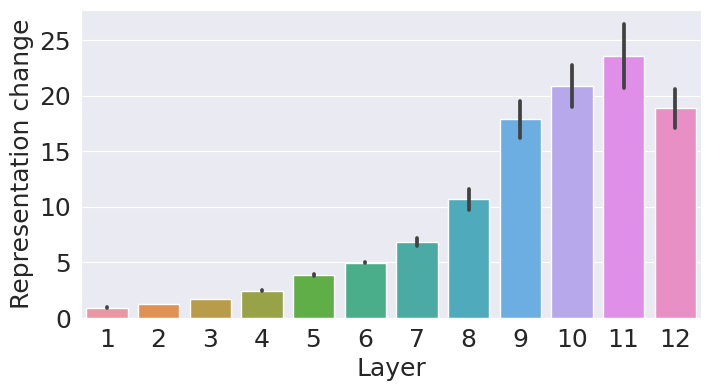

In [9]:
import my_datasets as md
import my_models as mm
import my_uncertainty as mu
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

with open('results-ood-repr-diff.pkl', 'rb') as f: 
    r = pickle.load(f)
    
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 18})
MODELS = ["RoBERTa"]
used_data = "AmazonReview"


for model_name in MODELS:
    data = []
    for data_name, run in r.items():
        if data_name != used_data: continue
        for seed in range(5):
            for distrib_name, uncer in run[model_name]["fine-tuned"][seed]["repr_change"].items():
                if distrib_name != "train": continue
                for i, layer in enumerate(uncer):
                    data.extend(zip(layer, [i+1]*len(layer), [data_name]*len(layer), [seed]*len(layer)))
    df = pd.DataFrame(data=data, columns=["Representation change", "Layer", "Dataset", "Seed"])
    sns.set_style("darkgrid")
    fig = sns.barplot(data=df[(df["Dataset"] == used_data)&(df["Seed"]==0)], x="Layer", y="Representation change", errorbar="sd")
    #fig.title.set_text(model_name)
    plt.savefig(f"repr_change_{model_name}-{used_data}.pdf", bbox_inches="tight", dpi=600)
    plt.show()

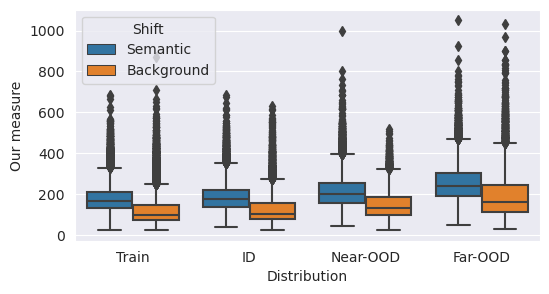

In [2]:
import my_datasets as md
import my_models as mm
import my_uncertainty as mu
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns
    
plt.rcParams["figure.figsize"] = [6, 3]
MODELS = ["RoBERTa", "ELECTRA"]
MODEL_TO_SHOW = "RoBERTa"
data = []
name_map = {"train":"Train", "id": "ID", "shifted":"Near-OOD", "ood": "Far-OOD"}


with open('results-ood-shifted.pkl', 'rb') as f: 
    r = pickle.load(f)    
for data_name, run in r.items():
    for model_name in MODELS:
        for seed in range(5):
            for distrib_name, uncer in run[model_name]["fine-tuned"][seed]["geometric_grad"].items():
                data.extend(zip(uncer[-1,:], ["Semantic"]*len(uncer[-1,:]), [model_name]*len(uncer[-1,:]), [name_map[distrib_name]]*len(uncer[-1,:])))

with open('results-ood-shifted-sst.pkl', 'rb') as f: 
    r = pickle.load(f)
for data_name, run in r.items():
    for model_name in MODELS:
        for seed in range(5):
            for distrib_name, uncer in run[model_name]["fine-tuned"][seed]["geometric_grad"].items():
                data.extend(zip(uncer[-1,:], ["Background"]*len(uncer[-1,:]), [model_name]*len(uncer[-1,:]), [name_map[distrib_name]]*len(uncer[-1,:])))
                

data_df = [[x[0].item(), x[1], x[2], x[3]] for x in data]
df = pd.DataFrame(data=data_df, columns=["Our measure", "Shift", "Model", "Distribution"])
sns.set_style("darkgrid")
sns.boxplot(data=df[df["Model"]==MODEL_TO_SHOW], x="Distribution", y="Our measure", hue="Shift")
plt.savefig(f"shifted_{MODEL_TO_SHOW}.pdf", bbox_inches="tight", dpi=600)
plt.show()

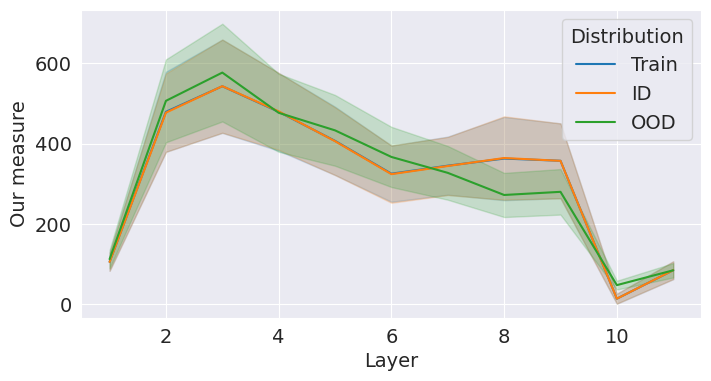

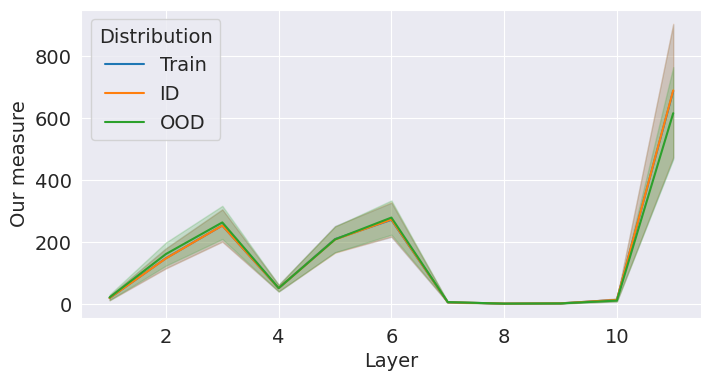

In [6]:
import my_datasets as md
import my_models as mm
import my_uncertainty as mu
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

with open('results-ood-multi-amazon.pkl', 'rb') as f: 
    r = pickle.load(f)
    
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 14})
MODELS = ["RoBERTa", "ELECTRA"]
name_map = {"train":"Train", "id": "ID", "shifted":"Shifted", "ood": "OOD"}
data_name = list(r.keys())[0]
use_data = "AmazonReview"


for model_name in MODELS:
    data = []
    for data_name, run in r.items():
        if data_name != use_data: continue
        for distrib_name, uncer in run[model_name]["pre-trained"].items():
            if distrib_name == "CKA": continue
            for i, layer in enumerate(uncer):
                data.extend(zip(layer, [i+1]*len(layer), [name_map[distrib_name]]*len(layer)))
     
    data_df = [[x[0].item(), x[1], x[2]] for x in data]
    df = pd.DataFrame(data=data_df, columns=["Our measure", "Layer", "Distribution"])
    sns.set_style("darkgrid")
    fig = sns.lineplot(data=df, x="Layer", y="Our measure", errorbar="sd", hue="Distribution")
    plt.savefig(f"layers_{use_data}_{model_name}_PT.pdf", bbox_inches="tight", dpi=600)
    plt.show()

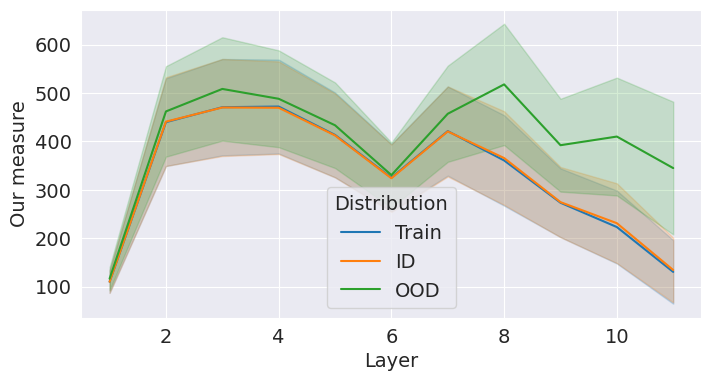

In [8]:
import my_datasets as md
import my_models as mm
import my_uncertainty as mu
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

with open('results-ood-multi-amazon.pkl', 'rb') as f: 
    r = pickle.load(f)
    
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 14})
MODELS = ["RoBERTa"]
name_map = {"train":"Train", "id": "ID", "shifted":"Shifted", "ood": "OOD"}
data_name = list(r.keys())[0]
use_data = "AmazonReview"


for model_name in MODELS:
    data = []
    for data_name, run in r.items():
        if data_name != use_data: continue
        for seed in [0]:
            for distrib_name, uncer in run[model_name]["fine-tuned"][seed]["geometric_grad"].items():
                for i, layer in enumerate(uncer):
                    data.extend(zip(layer, [i+1]*len(layer), [name_map[distrib_name]]*len(layer)))
     
    data_df = [[x[0].item(), x[1], x[2]] for x in data]
    df = pd.DataFrame(data=data_df, columns=["Our measure", "Layer", "Distribution"])
    sns.set_style("darkgrid")
    fig = sns.lineplot(data=df, x="Layer", y="Our measure", errorbar="sd", hue="Distribution")
    plt.savefig(f"layers_{use_data}_{model_name}_FT.pdf", bbox_inches="tight", dpi=600)
    plt.show()